$$ \beta\,(u-v) - \frac{d}{dx}\left(m_u\frac{du}{dx}\right) = f_1\qquad x\in\,(0,L)$$
$$ \beta\,(v-u) - \frac{d}{dx}\left(m_v\frac{dv}{dx}\right) = f_2\qquad x\in\,(0,L)$$

In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

def u_sol(x, kwargs):
    return kwargs['N'] + kwargs['O']*np.sin(kwargs['P']*(x-kwargs['Q']))

def dudx_sol(x, kwargs):
    return kwargs['O']*kwargs['P']*np.cos(kwargs['P']*(x-kwargs['Q']))

def d2udx2_sol(x, kwargs):
    return -kwargs['O']*np.square(kwargs['P'])*np.sin(kwargs['P']*(x-kwargs['Q']))


def v_sol(x, kwargs):
    return kwargs['R'] + kwargs['S']*np.exp(-kwargs['T']*x)

def dvdx_sol(x, kwargs):
    return -kwargs['S']*kwargs['T']*np.exp(-kwargs['T']*x)

def d2vdx2_sol(x, kwargs):
    return kwargs['S']*np.square(kwargs['T'])*np.exp(-kwargs['T']*x)


def m_u(x, kwargs):
    return kwargs['D'] + kwargs['E']*np.sin(kwargs['F']*(x-kwargs['G']))

def dm_udx(x, kwargs):
    return kwargs['E']*kwargs['F']*np.cos(kwargs['F']*(x-kwargs['G']))


def m_v(x, kwargs):
    return kwargs['H'] + kwargs['I']*np.sin(kwargs['L']*(x-kwargs['M']))

def dm_vdx(x, kwargs):
    return kwargs['I']*kwargs['L']*np.cos(kwargs['L']*(x-kwargs['M']))


def f_1(x, kwargs):
    return kwargs['beta']*(u_sol(x, kwargs)-v_sol(x, kwargs)) - (dm_udx(x, kwargs)*dudx_sol(x, kwargs) + m_u(x, kwargs)*d2udx2_sol(x, kwargs))

def f_2(x, kwargs):
    return kwargs['beta']*(v_sol(x, kwargs)-u_sol(x, kwargs)) - (dm_vdx(x, kwargs)*dvdx_sol(x, kwargs) + m_v(x, kwargs)*d2vdx2_sol(x, kwargs))

In [ ]:

L = 2.0*np.pi
N = 32
x = np.linspace(0, L, N+1) #faces coordinates
xc = np.linspace(0.5*np.divide(L, N), L-0.5*np.divide(L, N), N) #centercells coordinates
xfine = np.linspace(0, L, 1000)
omega = 1.5 # SOR relaxation factor
nit_max = 200
toll = 1e-8

err = {
    "BJ":  {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BGS": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BSOR":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJ": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJ":{"nit":[], "u_errl2":[], "v_errl2":[]},
    "mono":{"u_errl2":[], "v_errl2":[]}
    }

fig1, axs1 = plt.subplots(2, 1, figsize=(8,4), dpi=150, sharex=True)
fig2, axs2 = plt.subplots(1, 1, figsize=(8,4), dpi=150, sharex=True)
fig3, axs3 = plt.subplots(1, 1, figsize=(8,4), dpi=150, sharex=True)

beta = np.logspace(-1, 4, 20)
# beta = np.linspace(0.1, 1, 5)
# beta = [0.001]

for val in beta:
    kwargs = {
        'beta': val,
        # 'A': 1.0, 
        # 'B': 0.2,
        # 'C': 1.0,

        # m_u and m_v 
        'D': 1.0, #constant
        'E': 0.0, #amplitude
        'F': 4.0, #frequency
        'G': 0.0, #shift

        'H': 100.0,#1000.0, #constant
        'I': 0.0,#-999.999, #amplitude
        'L': 3.5, #frequency
        'M': 0.0, #shift

        # solutions
        'N': -0.5,
        'O': 0.3,
        'P': 1.5,
        'Q': 0.0,

        'R': -0.5,
        'S': 1.0,
        'T': 2.0
    }

    leftBC_u = {
        'type':'dirichlet', #'type':'neumann',
        'value':u_sol(0.0, kwargs)}

    rightBC_u = {
        'type':'dirichlet', #'type':'neumann',
        'value':u_sol(L, kwargs)}

    leftBC_v = {
        'type':'dirichlet', #'type':'neumann',
        'value':v_sol(0.0, kwargs)}

    rightBC_v = {
        'type':'dirichlet', #'type':'neumann',
        'value':v_sol(L, kwargs)}

    A_laplacian, f1BC = mylib.fvm_laplacian_1D(m_u, leftBC_u, rightBC_u, N, L, kwargs)
    D_laplacian, f2BC = mylib.fvm_laplacian_1D(m_v, leftBC_v, rightBC_v, N, L, kwargs)
    A = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - A_laplacian)
    B = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
    C = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
    D = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - D_laplacian)

    f1 = f_1(xc, kwargs) - f1BC
    f2 = f_2(xc, kwargs) - f2BC

    Z = np.zeros((2*N,2*N))
    Z[:N,:N] = A.toarray()
    Z[:N,N:] = B.toarray()
    Z[N:,:N] = C.toarray()
    Z[N:,N:] = D.toarray()
    Z = sparse.csc_matrix(Z)
    f = np.concatenate((f1,f2))
    sol = sparse.linalg.spsolve(Z, f)
    u = sol[:N]
    v = sol[N:]
    u_rec = mylib.fvm_reconstruct_1D(u)
    v_rec = mylib.fvm_reconstruct_1D(v)
    
    err['mono']['u_errl2'].append((np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u))/np.linalg.norm(u_sol(x, kwargs))))
    err['mono']['v_errl2'].append((np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v))/np.linalg.norm(v_sol(x, kwargs))))

    u_BJ,   v_BJ,   res_BJ,   nitfinal_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
    u_BGS,  v_BGS,  res_BGS,  nitfinal_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
    # u_BSOR, v_BSOR, res_BSOR, nitfinal_BSOR = mylib.method_BlockSOR(             A, B, C, D, f1, f2, nit_max, omega, sol, toll)
    u_SPJ,  v_SPJ,  res_SPJ,  nitfinal_SPJ  = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll)
    u_S2PJ, v_S2PJ, res_S2PJ, nitfinal_S2PJ = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll)


######################################

    Z = Z.toarray()
    A = A.toarray()
    B = B.toarray()
    C = C.toarray()
    D = D.toarray()

    err['BJ']['nit'].append(nitfinal_BJ)
    err['BJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BJ)))
    err['BJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BJ)))
    err['BGS']['nit'].append(nitfinal_BGS)
    err['BGS']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BGS)))
    err['BGS']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BGS)))
    # err['BSOR']['nit'].append(nitfinal_BSOR)
    # err['BSOR']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BSOR)))
    # err['BSOR']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BSOR)))
    err['SPJ']['nit'].append(nitfinal_SPJ)
    err['SPJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJ)))
    err['SPJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJ)))
    err['S2PJ']['nit'].append(nitfinal_S2PJ)
    err['S2PJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJ)))
    err['S2PJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJ))) 

    ##################################################################

    markersize = 4
    linewidth = 0.8

    # axs1[0].plot(x, 0*x, '|', color='k', markersize=6.0)
    # axs1[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
    axs1[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth, markersize=markersize)
    axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJ), 'xr' , label=r'$u_{rec,SPJ}$', linewidth=linewidth, markersize=markersize)
    axs1[0].plot(x, mylib.fvm_reconstruct_1D(u_S2PJ), '+g' , label=r'$u_{rec,S2PJ}$', linewidth=linewidth)
    # axs1[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
    axs1[0].plot(xfine, u_sol(xfine, kwargs), '-b', label=r'$u(x)$')
    # axs1[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
    # axs1[0].plot(xfine, f_1(xfine, kwargs), '--c', label=r'$f_u(x)$')

    # axs1[1].plot(x, 0*x, '|', color='k', markersize=6.0)
    # axs1[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
    axs1[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth, markersize=markersize)
    axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJ), 'xr' , label=r'$v_{rec,SPJ}$', linewidth=linewidth, markersize=markersize)
    axs1[1].plot(x, mylib.fvm_reconstruct_1D(v_S2PJ), '+g' , label=r'$v_{rec,S2PJ}$', linewidth=linewidth)
    # axs1[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
    axs1[1].plot(xfine, v_sol(xfine, kwargs), '-b', label=r'$v(x)$')
    # axs1[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
    # axs1[1].plot(xfine, f_2(xfine, kwargs), '--c', label=r'$f_v(x)$')

axs1[0].set_xlabel(r'$x$')
axs1[0].set_ylabel(r'$u,f_u$')
axs1[0].grid()
axs1[1].set_xlabel(r'$x$')
axs1[1].set_ylabel(r'$v,f_v$')
axs1[1].grid()
# axs1[0].legend()
# axs1[1].legend()


axs2.loglog(beta, err['BJ']['nit'], '.-', label=r'$BJ$')
axs2.loglog(beta, err['BGS']['nit'], '.-', label=r'$BGS$')
axs2.loglog(beta, err['SPJ']['nit'], 'x-', label=r'$SPJ^2$')
axs2.loglog(beta, err['S2PJ']['nit'], '+-', label=r'$S2PJ$')
axs2.set_xlabel(r"$\beta$")
axs2.set_ylabel(r"$number~of~iterations$")
axs2.grid()
axs2.legend()
# fig2.savefig('./figures/iterations_dp.pdf')


axs3.loglog(beta, err['mono']['u_errl2'], 's-', label=r'$Monolithic$')
# axs3.loglog(beta, err['BJ']['u_errl2'], '.-', label=r'$BJ$')
# axs3.loglog(beta, err['BGS']['u_errl2'], '.-', label=r'$BGS$')
axs3.loglog(beta, err['SPJ']['u_errl2'], 'x-', label=r'$SPJ^2$')
# axs3.loglog(beta, err['S2PJ']['u_errl2'], '+-', label=r'$S2PJ$')
axs3.set_xlabel(r"$\beta$")
axs3.set_ylabel(r"$||u(x_f)-u_h(x_f)||_{\mathbb{R}^N}$")
axs3.grid()
axs3.legend()
# fig3.savefig('./figures/error_fixed_iterations_dp.pdf')

plt.show()

cond(Z) = 678.0835486637652
monolithic error = 2.8156372781589012e-14
{'type': 'dirichlet', 'value': -0.5}
{'type': 'dirichlet', 'value': -0.4999999999999999}
{'type': 'dirichlet', 'value': 0.5}
{'type': 'dirichlet', 'value': -0.4999965126576438}


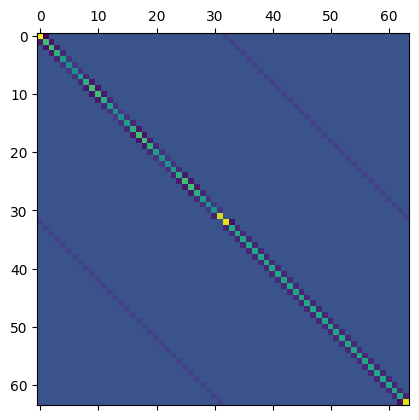

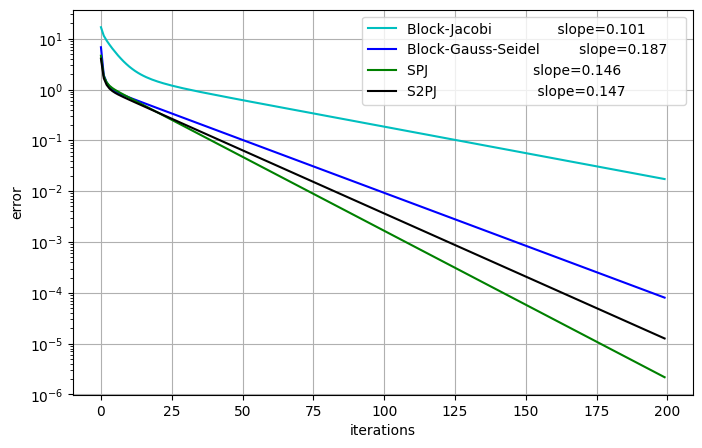

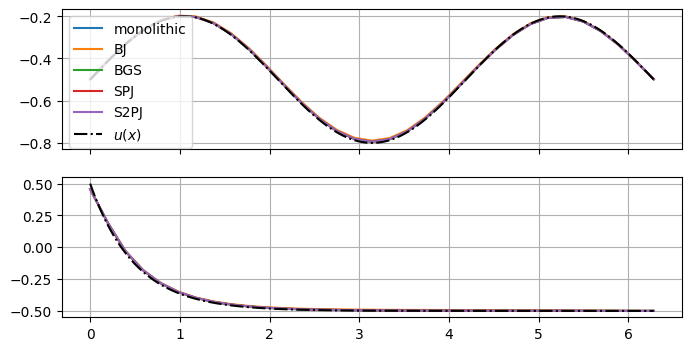

In [3]:
L = 2.0*np.pi
N = 32
x = np.linspace(0, L, N+1) #faces coordinates
xc = np.linspace(0.5*np.divide(L, N), L-0.5*np.divide(L, N), N) #centercells coordinates
xfine = np.linspace(0, L, 1000)
omega = 1.5 # SOR relaxation factor
nit_max = 200
toll = 1e-6

kwargs = {
    'beta': 10,
    # 'A': 1.0, 
    # 'B': 0.2,
    # 'C': 1.0,

    # m_u and m_v 
    'D': 1.0, #constant
    'E': 0.4, #amplitude
    'F': 4.0, #frequency
    'G': 0.0, #shift

    'H': 1.0,#1000.0, #constant
    'I': 0.0,#-999.999, #amplitude
    'L': 3.5, #frequency
    'M': 0.0, #shift

    # solutions
    'N': -0.5,
    'O': 0.3,
    'P': 1.5,
    'Q': 0.0,

    'R': -0.5,
    'S': 1.0,
    'T': 2.0
}

leftBC_u  = {'type':'dirichlet', 'value':u_sol(0.0, kwargs)}
leftBC_v  = {'type':'dirichlet', 'value':v_sol(0.0, kwargs)}
rightBC_u = {'type':'dirichlet', 'value':u_sol(L, kwargs)}
rightBC_v = {'type':'dirichlet', 'value':v_sol(L, kwargs)}

A_laplacian, f1BC = mylib.fvm_laplacian_1D(m_u, leftBC_u, rightBC_u, N, L, kwargs)
D_laplacian, f2BC = mylib.fvm_laplacian_1D(m_v, leftBC_v, rightBC_v, N, L, kwargs)
A = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - A_laplacian)
B = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
C = sparse.csc_matrix(-kwargs['beta']*sparse.eye(N))
D = sparse.csc_matrix( kwargs['beta']*sparse.eye(N) - D_laplacian)

f1 = f_1(xc, kwargs) - f1BC
f2 = f_2(xc, kwargs) - f2BC

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()
Z = sparse.csc_matrix(Z)
f = np.concatenate((f1,f2))
sol = sparse.linalg.spsolve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)
    

u_BJ,   v_BJ,   res_BJ,   nitfinal_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
u_BGS,  v_BGS,  res_BGS,  nitfinal_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
u_SPJ,  v_SPJ,  res_SPJ,  nitfinal_SPJ  = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll)
u_S2PJ, v_S2PJ, res_S2PJ, nitfinal_S2PJ = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll)

Z = Z.toarray()
mats = [A.toarray(), B.toarray(), C.toarray(), D.toarray()]
mats_names = ['A','B','C','D']

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z, sol))}")
print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)


plt.matshow(Z, aspect='equal')

plt.figure(figsize=(8,5), dpi=100)
nn = 5
plt.semilogy(res_BJ,  'c-',  label=f"Block-Jacobi               slope={np.round(-mylib.slope(res_BJ[:nn]), 3)}")
plt.semilogy(res_BGS, 'b-',  label=f"Block-Gauss-Seidel         slope={np.round(-mylib.slope(res_BGS[:nn]), 3)}   ")
plt.semilogy(res_SPJ, 'g-',  label=f"SPJ                        slope={np.round(-mylib.slope(res_SPJ[:nn]), 3)}", markersize=10)
plt.semilogy(res_S2PJ,'k-',  label=f"S2PJ                       slope={np.round(-mylib.slope(res_S2PJ[:nn]), 3)}")
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
# plt.savefig('figures/error1.pdf')

fig, axs = plt.subplots(2, 1, figsize=(8,4), dpi=100, sharex=True)
axs[0].plot(x, mylib.fvm_reconstruct_1D(u),     label='monolithic')
axs[0].plot(x, mylib.fvm_reconstruct_1D(u_BJ),  label='BJ')
axs[0].plot(x, mylib.fvm_reconstruct_1D(u_BGS),  label='BGS')
axs[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJ), label='SPJ')
axs[0].plot(x, mylib.fvm_reconstruct_1D(u_S2PJ),label='S2PJ')
axs[0].plot(xfine, u_sol(xfine, kwargs), 'k-.', label=r'$u(x)$')

axs[1].plot(x, mylib.fvm_reconstruct_1D(v),     label='monolithic')
axs[1].plot(x, mylib.fvm_reconstruct_1D(v_BJ),  label='BJ')
axs[1].plot(x, mylib.fvm_reconstruct_1D(v_BGS),  label='BGS')
axs[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJ), label='SPJ')
axs[1].plot(x, mylib.fvm_reconstruct_1D(v_S2PJ),label='S2PJ')
axs[1].plot(xfine, v_sol(xfine, kwargs), 'k-.', label=r'$v(x)$')

for val in axs: val.grid()
axs[0].legend()

plt.show()